# Chapter 11 - Exercises

In [1]:
library(tidyverse)
library(bayesrules)
library(bayesplot)
library(rstan)
library(rstanarm)
library(broom.mixed)
library(tidybayes)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: StanHeaders

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recomp

Restrict penguin data to two species:

In [2]:
penguin_data <- penguins_bayes %>% 
  filter(species %in% c("Adelie", "Gentoo"))
penguin_data$species <- as.factor( as.character(penguin_data$species) )

## Exercise 11.10

### a)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


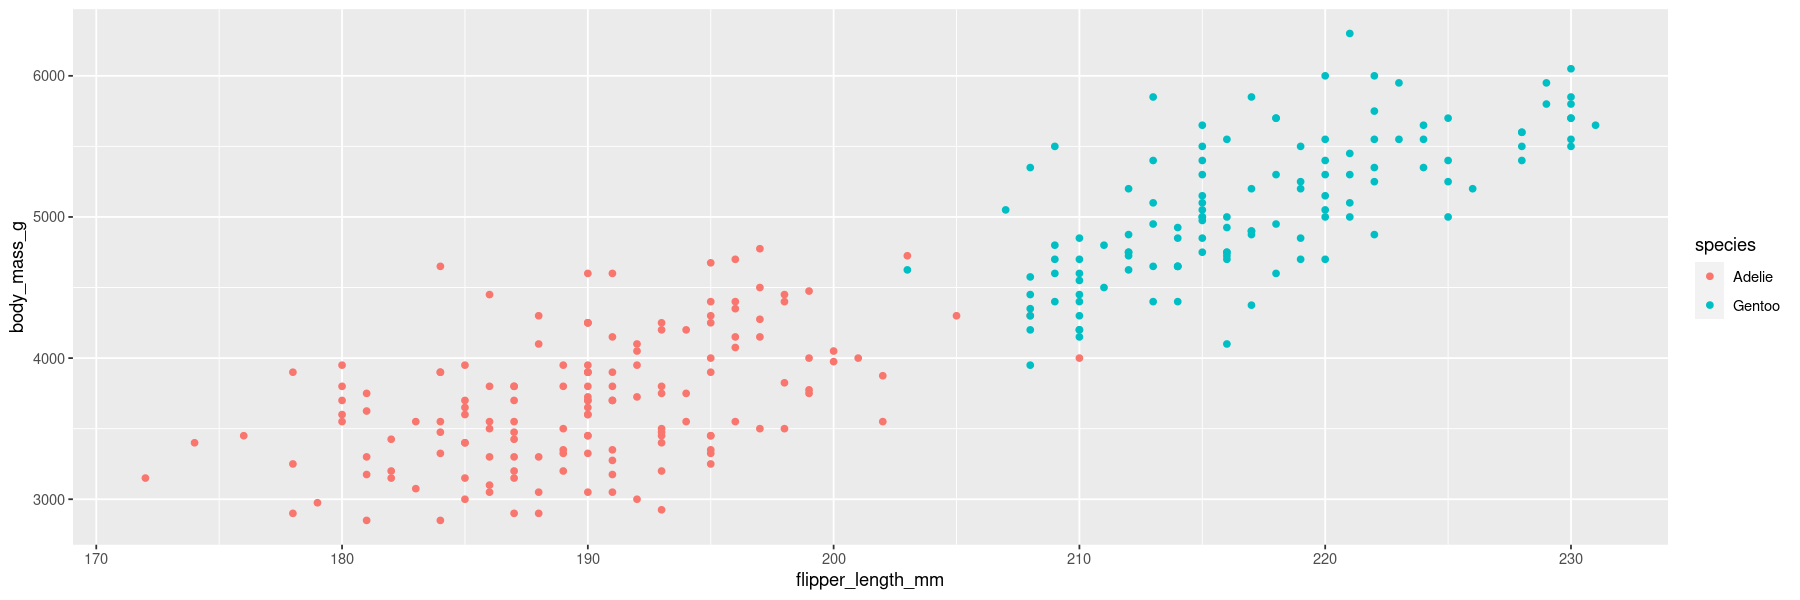

In [3]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( penguin_data, aes(x=flipper_length_mm, y=body_mass_g, color=species) ) + geom_point()

### b)

In [4]:
penguin_model_1 <- stan_glm(
  body_mass_g ~ flipper_length_mm + species, 
  data = penguin_data, family = gaussian,
  prior_intercept = normal(4000, autoscale=TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.321565 seconds (Warm-up)
Chain 1:                0.392036 seconds (Sampling)
Chain 1: 

### c)

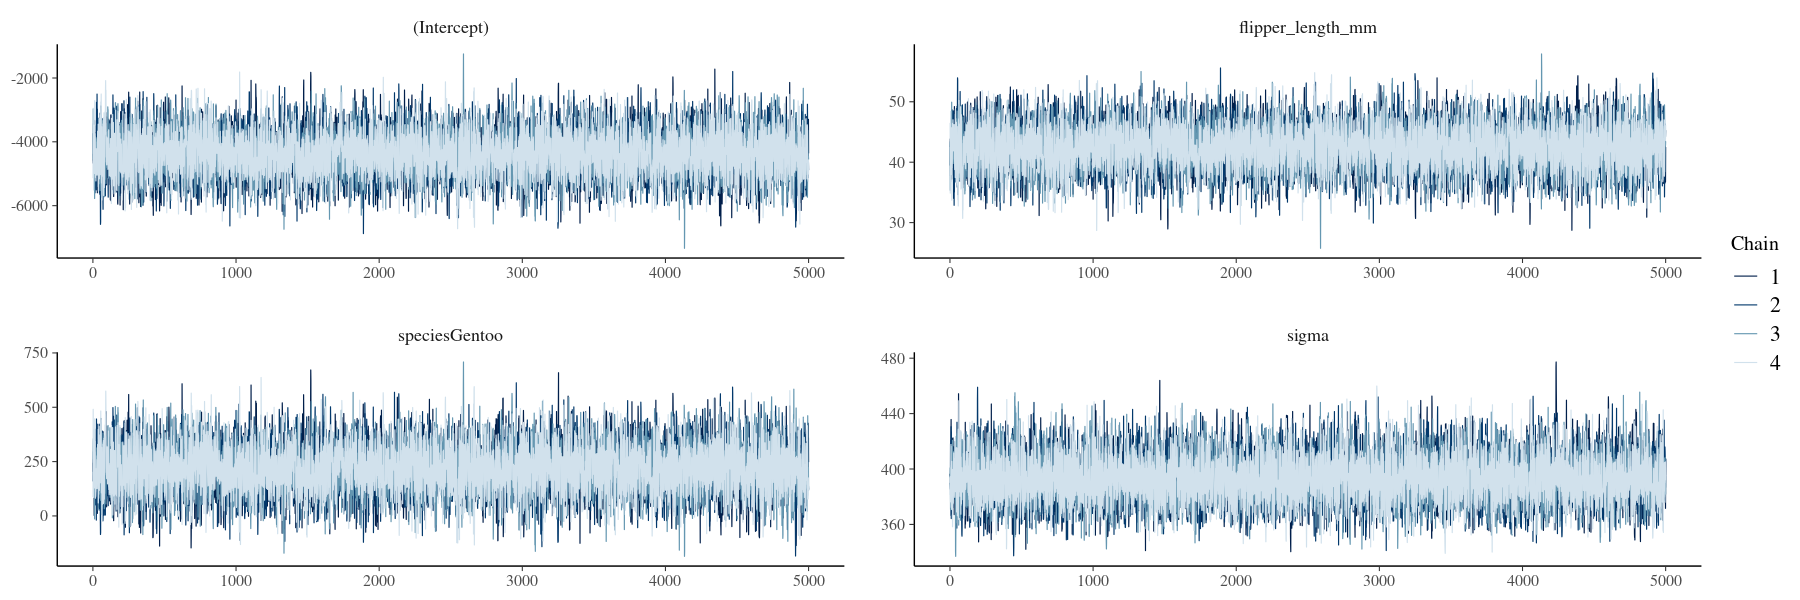

In [5]:
mcmc_trace( penguin_model_1 )

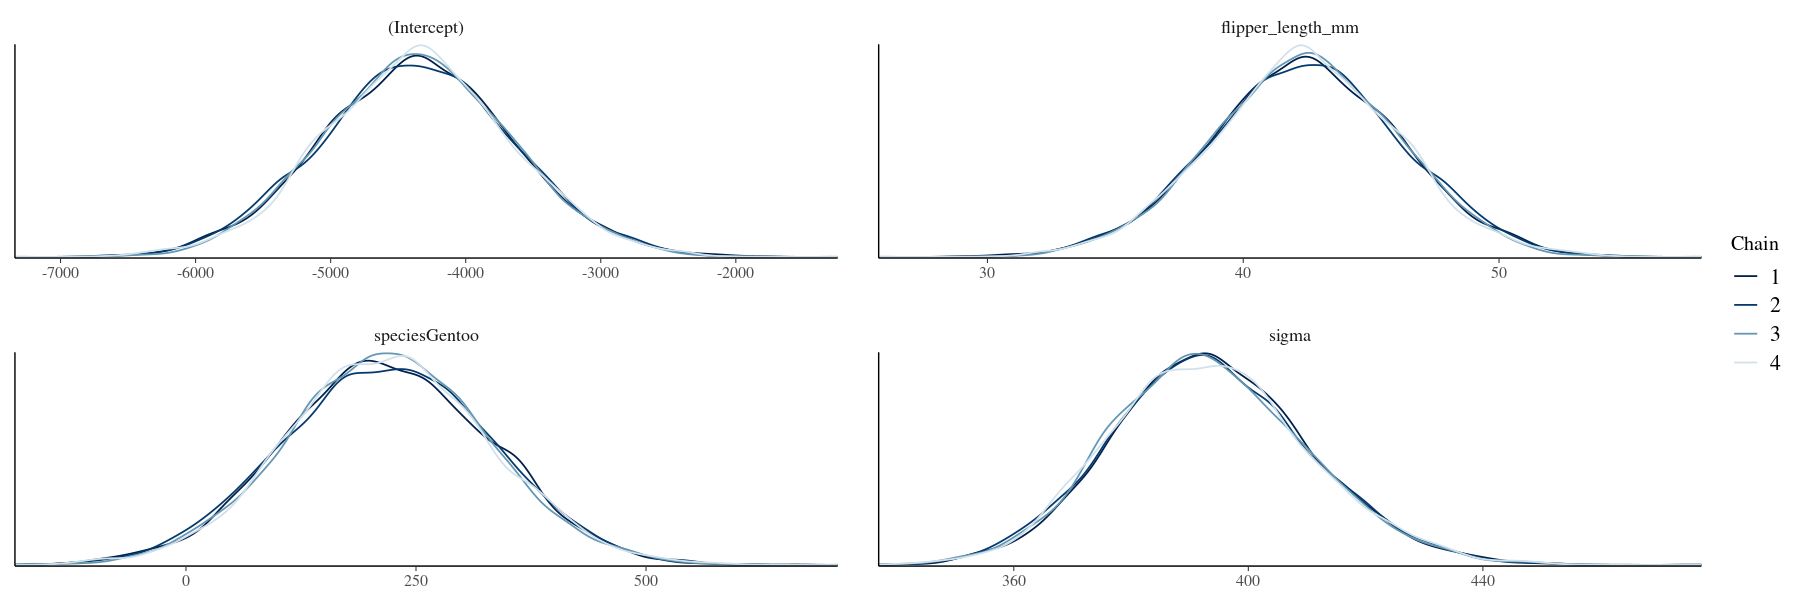

In [6]:
mcmc_dens_overlay( penguin_model_1 )

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>.”


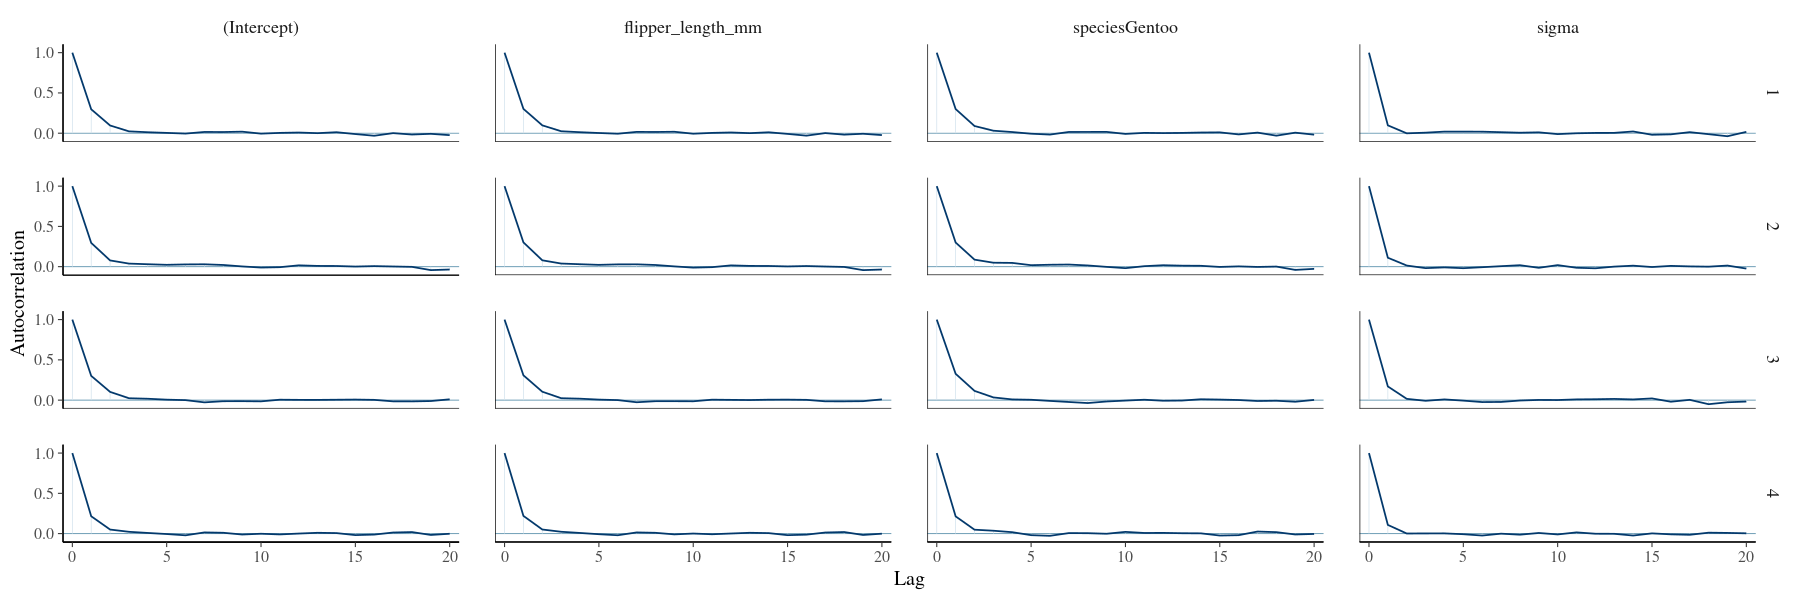

In [7]:
mcmc_acf( penguin_model_1 )

In [8]:
rhat( penguin_model_1 )

(Intercept) flipper_length_mm     speciesGentoo             sigma 
         1.000303          1.000320          1.000318          1.000172

In [9]:
neff_ratio( penguin_model_1 )

(Intercept) flipper_length_mm     speciesGentoo             sigma 
          0.53945           0.53480           0.53825           0.79645

All the chains are mixing well and have converged to the same densities.

### d)

In [10]:
tidy(penguin_model_1, effects = c("fixed", "aux"),
     conf.int = TRUE, conf.level = 0.80) %>% 
    select(-std.error)

term,estimate,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
(Intercept),-4360.19767,-5263.29935,-3462.81518
flipper_length_mm,42.44047,37.71552,47.17711
speciesGentoo,218.87884,77.85852,363.30256
sigma,392.95857,372.37555,415.82521
mean_PPD,4317.93223,4275.03632,4361.36760


In the median, when the flipper length changes by 1 mm, the body mass goes up by 42g. Gentoo penguins are in the median 219g heavier than Adelie penguins.

### e)

Posterior predictive model for body mass of Adelie penguin with flipper length 197 mm:

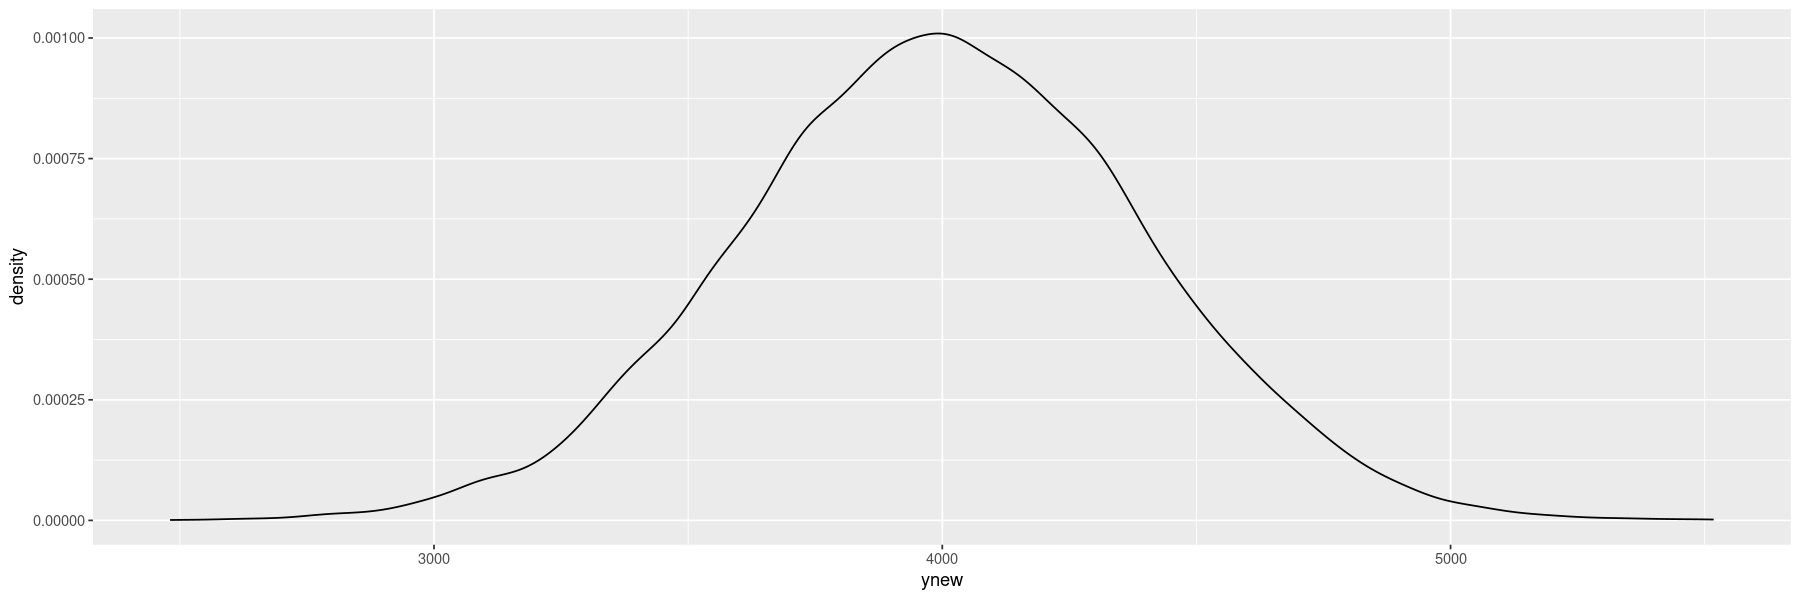

In [11]:
x1 = 197
x2 = 0

penguin_model_1_df <- data.frame( penguin_model_1 )

ggplot(
    data = penguin_model_1_df %>% 
        mutate( mu=X.Intercept. + flipper_length_mm*x1 + speciesGentoo*x2 ) %>% 
        mutate( ynew=rnorm(nrow(penguin_model_1_df), mean=mu, sd=sigma) )
    ) + geom_density( aes(x=ynew) )

## Exercise 11.11

In [12]:
penguin_model_2 <- stan_glm(
  body_mass_g ~ flipper_length_mm + species + flipper_length_mm:species, 
  data = penguin_data, family = gaussian,
  prior_intercept = normal(4000, autoscale=TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.62515 seconds (Warm-up)
Chain 1:                2.80085 seconds (Sampling)
Chain 1:   

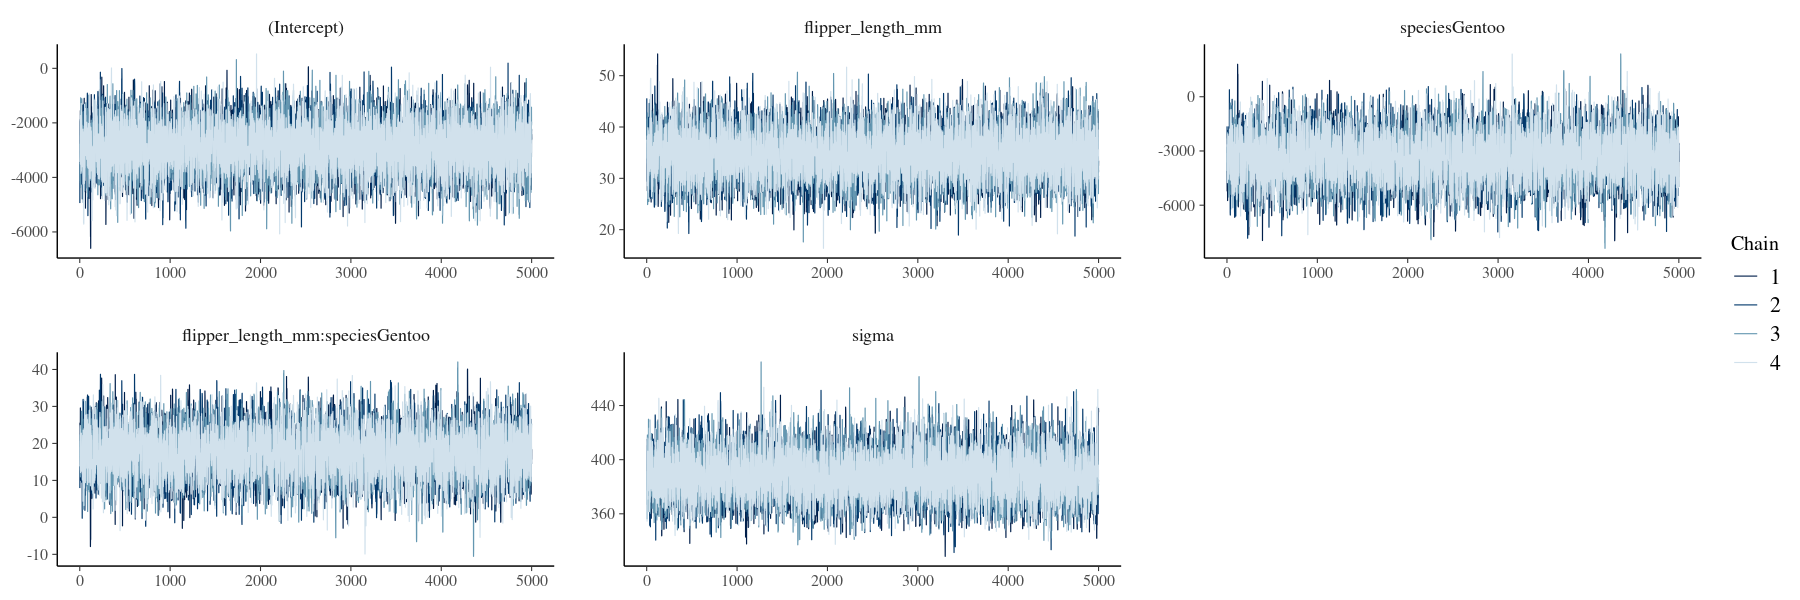

In [13]:
mcmc_trace( penguin_model_2 )

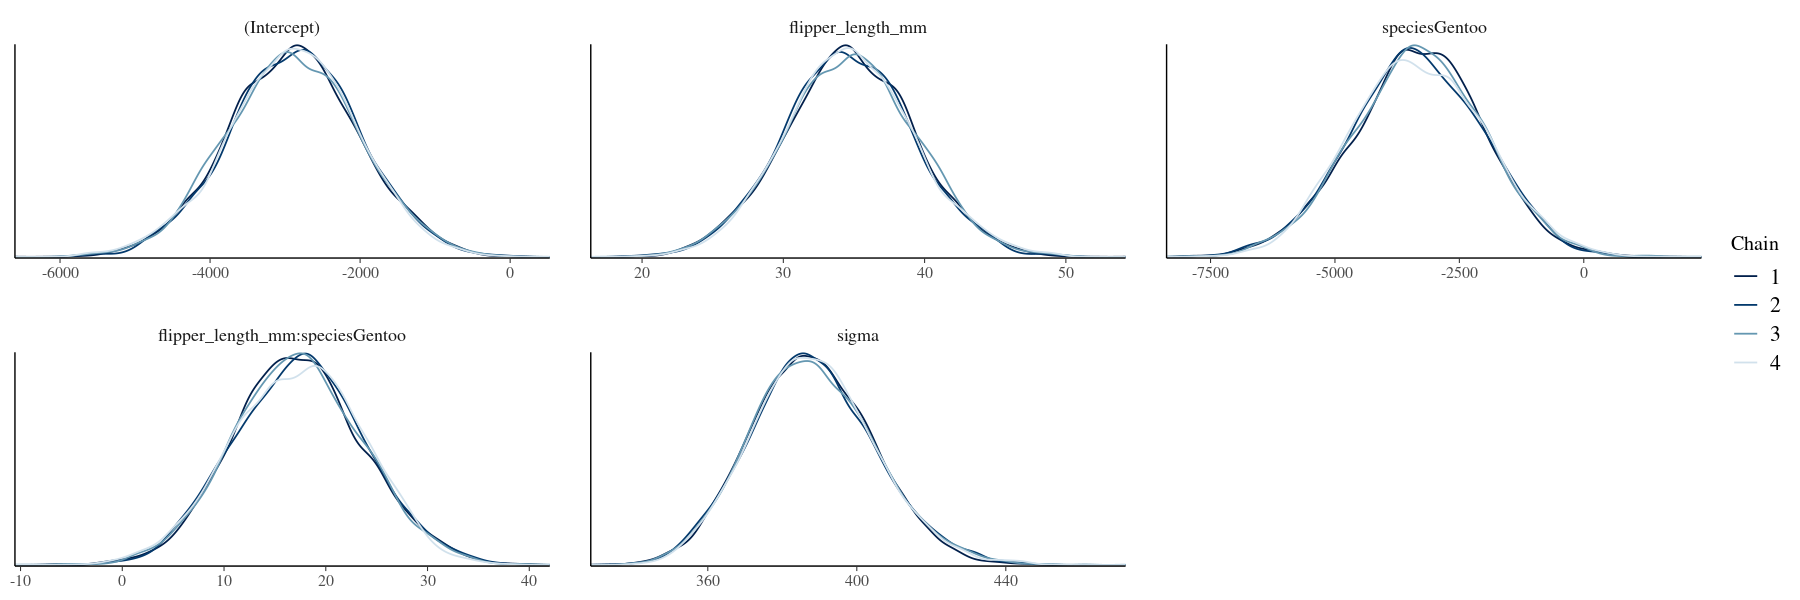

In [14]:
mcmc_dens_overlay( penguin_model_2 )

### b)

Warning message:
“`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`.”


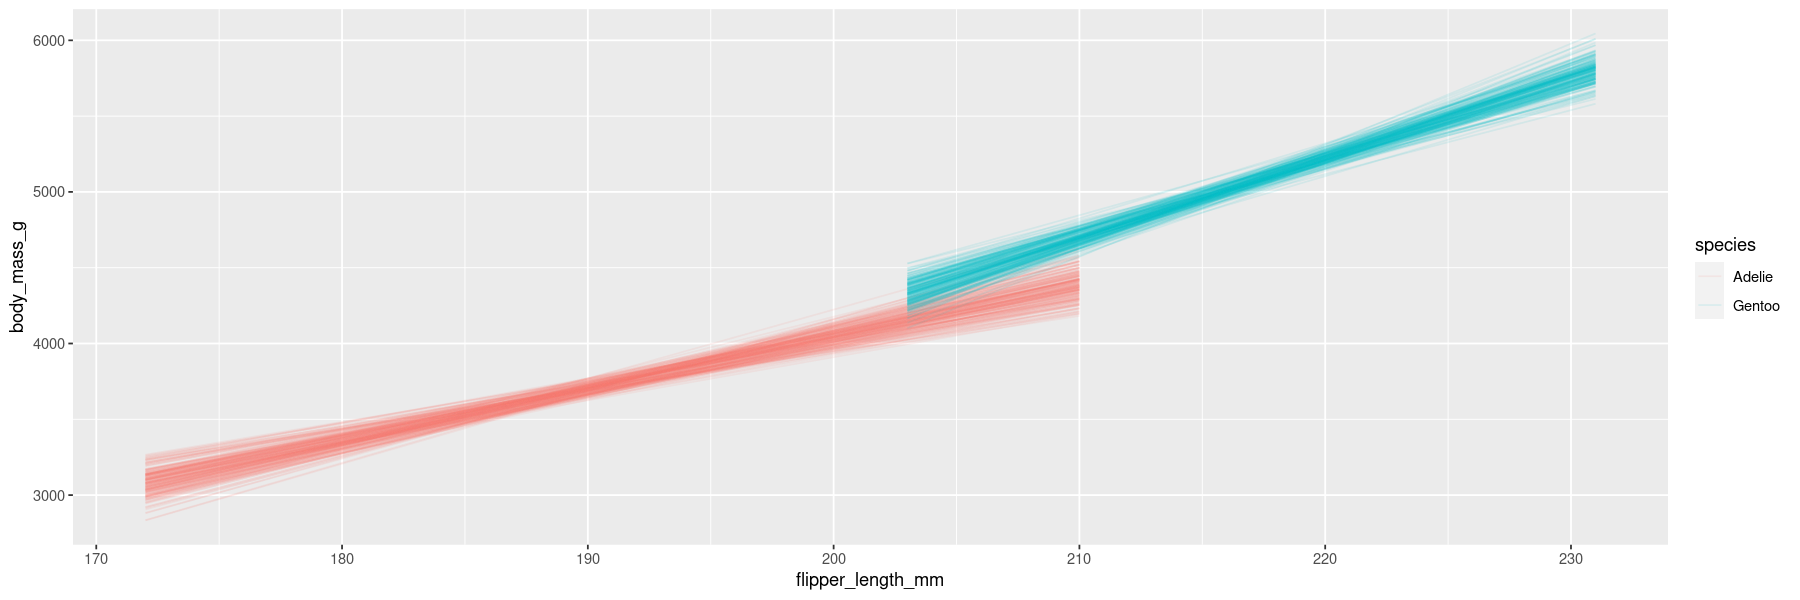

In [15]:
penguin_data %>%
  filter( !is.na(body_mass_g), !is.na(flipper_length_mm), !is.na(species) ) %>% 
  add_fitted_draws(penguin_model_2, n = 200) %>%
  ggplot(aes(x = flipper_length_mm, y = body_mass_g, color = species)) +
    geom_line(aes(y = .value, group = paste(species, .draw)), alpha = 0.1)

There appears to be a steeper relationship between flipper length and body mass for Gentoo penguins. The interaction terms appears to make sense.

### c)

In [16]:
tidy(penguin_model_2, effects = c("fixed", "aux"),
     conf.int = TRUE, conf.level = 0.95) %>% 
    select(-std.error)

term,estimate,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
(Intercept),-2883.84733,-4631.733123,-1179.83708
flipper_length_mm,34.65458,25.703572,43.85335
speciesGentoo,-3336.57565,-5940.358110,-788.44371
flipper_length_mm:speciesGentoo,17.31354,4.979456,30.01400
sigma,387.58420,357.221567,422.89977
mean_PPD,4318.00363,4252.470001,4382.77223


The coefficient of the interaction term is between 5 and 17 with a probability of 95%, therefore it is most certainly positive and the interaction term is necessary.

## Exercise 11.2

### a)

In [17]:
penguin_model_3 <- stan_glm(
  body_mass_g ~ flipper_length_mm + bill_length_mm + bill_depth_mm, 
  data = penguin_data, family = gaussian,
  prior_intercept = normal(4000, autoscale=TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.310524 seconds (Warm-up)
Chain 1:                0.453288 seconds (Sampling)
Chain 1: 

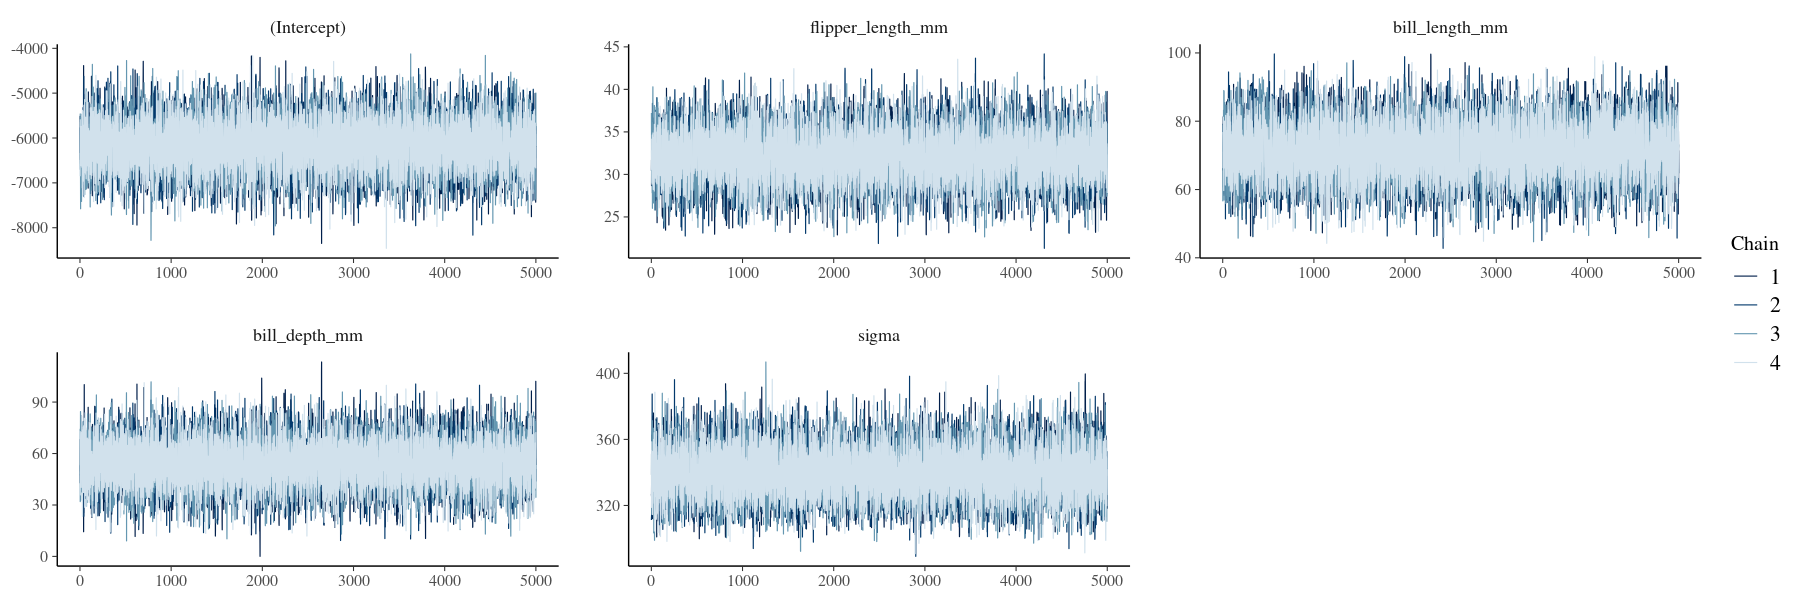

In [18]:
mcmc_trace( penguin_model_3 )

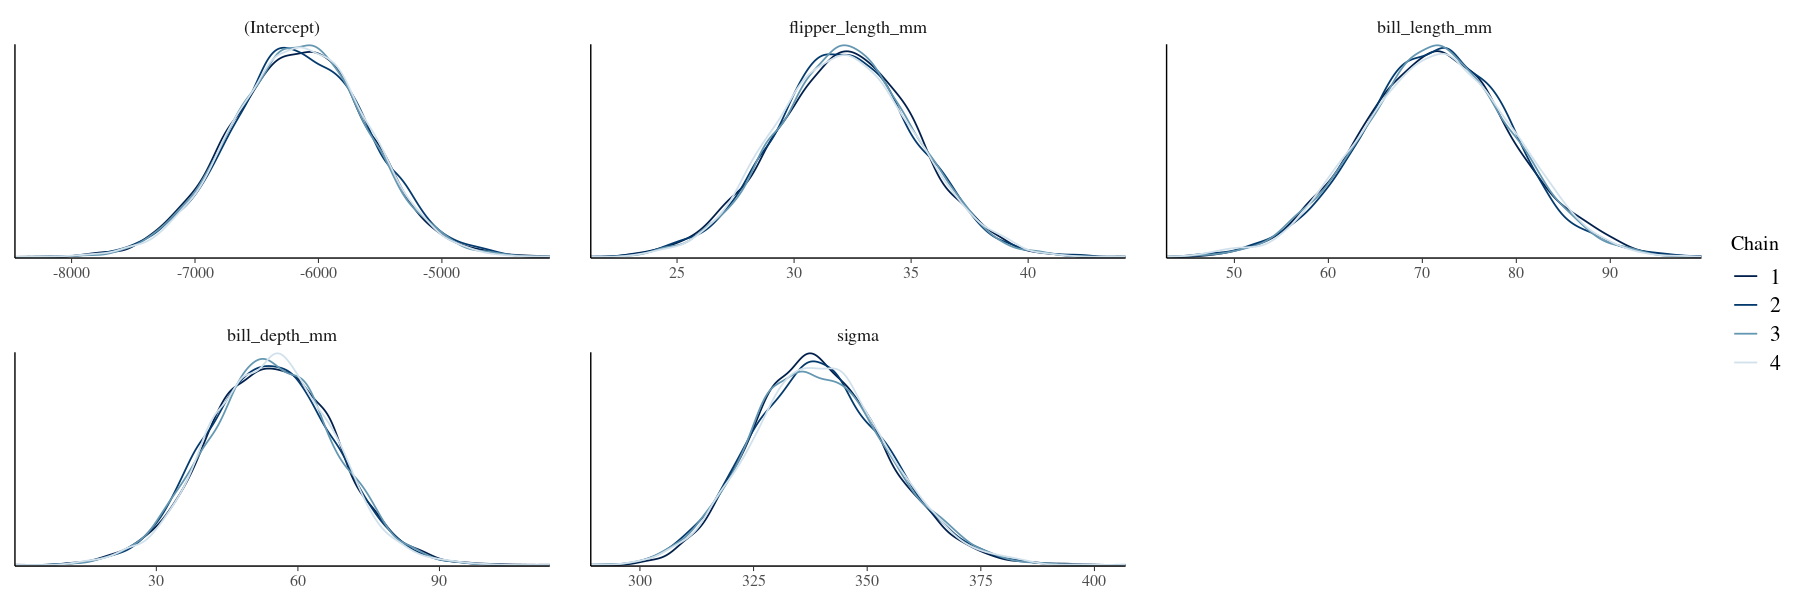

In [19]:
mcmc_dens_overlay( penguin_model_3 )

### b)

In [20]:
posterior_interval(penguin_model_3, prob = 0.95)

,2.5%,97.5%
(Intercept),-7235.03481,-5083.15029
flipper_length_mm,26.30110,38.01342
bill_length_mm,55.82686,87.32491
bill_depth_mm,28.12134,80.13658
sigma,311.91483,370.33752


### c)

All predictors have a significant positive association with body mass.

## Exercise 11.13

### a)

In [21]:
model_1 <- stan_glm(
  body_mass_g ~ flipper_length_mm, 
  data = penguin_data, family = gaussian,
  prior_intercept = normal(4000, autoscale=TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.185763 seconds (Warm-up)
Chain 1:                0.256687 seconds (Sampling)
Chain 1: 

In [22]:
model_2 <- stan_glm(
  body_mass_g ~ species,
  data = penguin_data, family = gaussian,
  prior_intercept = normal(4000, autoscale=TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.182782 seconds (Warm-up)
Chain 1:                0.262943 seconds (Sampling)
Chain 1: 

In [23]:
model_3 <- stan_glm(
  body_mass_g ~ flipper_length_mm + species,
  data = penguin_data, family = gaussian,
  prior_intercept = normal(4000, autoscale=TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.309028 seconds (Warm-up)
Chain 1:                0.394237 seconds (Sampling)
Chain 1: 

In [24]:
model_4 <- stan_glm(
  body_mass_g ~ flipper_length_mm + bill_length_mm + bill_depth_mm,
  data = penguin_data, family = gaussian,
  prior_intercept = normal(4000, autoscale=TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.308213 seconds (Warm-up)
Chain 1:                0.462811 seconds (Sampling)
Chain 1: 

### b)

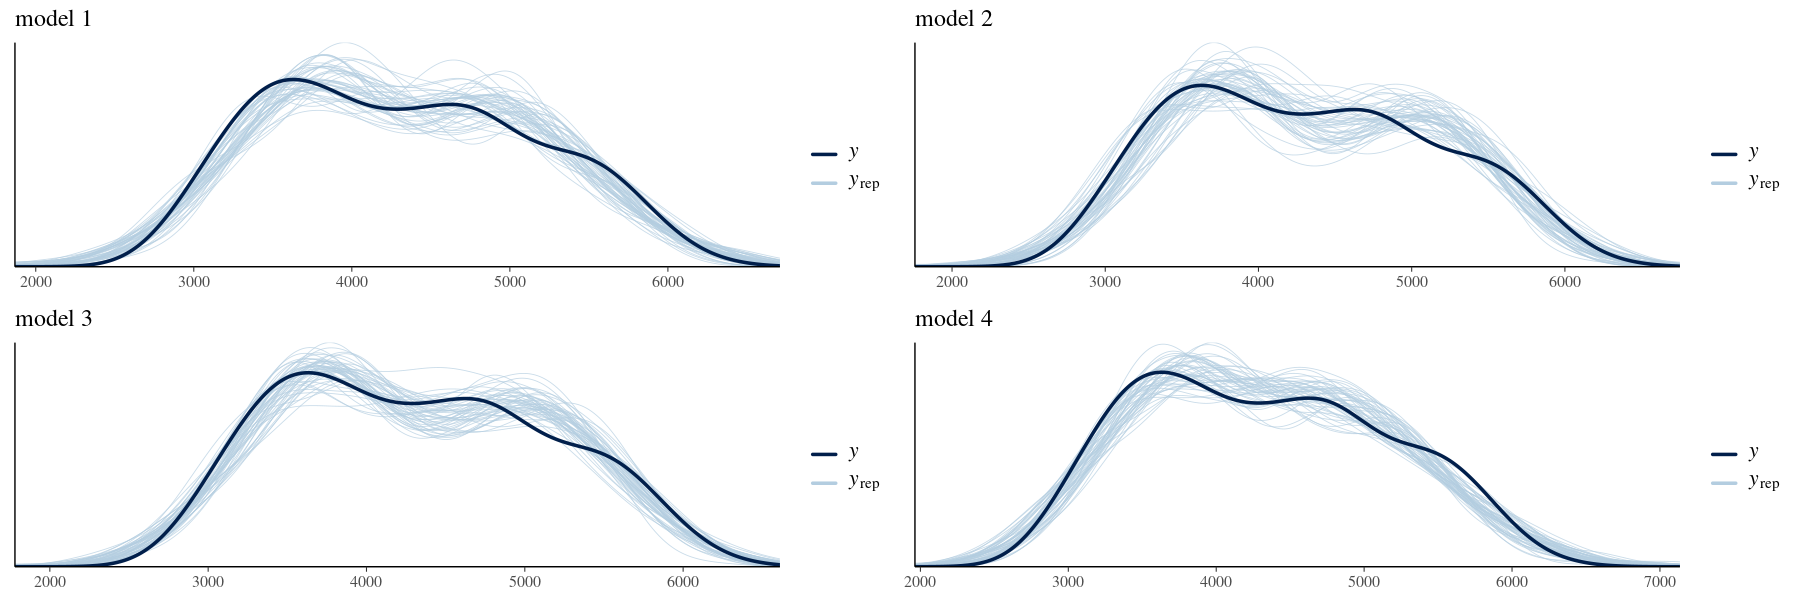

In [25]:
grid.arrange( 
    pp_check(model_1) + ggtitle("model 1"), 
    pp_check(model_2) + ggtitle("model 2"), 
    pp_check(model_3) + ggtitle("model 3"), 
    pp_check(model_4) + ggtitle("model 4")
)

It is not straightforward to select the model that mimicks the data distribution best. Probably model 4.

### c)

In [26]:
set.seed(84735)
penguins_complete <- penguins_bayes %>% 
  select(flipper_length_mm, body_mass_g, species, bill_length_mm, bill_depth_mm) %>% 
  na.omit() 
cv1 <- prediction_summary_cv(model = model_1, data = penguins_complete, k = 10)
cv2 <- prediction_summary_cv(model = model_2, data = penguins_complete, k = 10)
cv3 <- prediction_summary_cv(model = model_3, data = penguins_complete, k = 10)
cv4 <- prediction_summary_cv(model = model_4, data = penguins_complete, k = 10)

In [27]:
cv1$cv$name <- "model 1"
cv2$cv$name <- "model 2"
cv3$cv$name <- "model 3"
cv4$cv$name <- "model 4"
rbind( cv1$cv, cv2$cv, cv3$cv, cv4$cv )

mae,mae_scaled,within_50,within_95,name
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
272.4636,0.6880320,0.5173950,0.9530252,model 1
337.4902,0.7238764,0.4733613,0.9560504,model 2
276.1836,0.7302190,0.5052941,0.9474790,model 3
273.9585,0.6891857,0.5086555,0.9415966,model 4


Models 3 and 4 appear to have similar median absolute errors, lower than models 1 and 2, however not by a very large margin. Bill length and bill depth seem not to help much in explaining body mass in addition to the information available in flipper length.

### d)

In [28]:
set.seed(84735)
loo_1 <- loo(model_1)
loo_2 <- loo(model_2)
loo_3 <- loo(model_3)
loo_4 <- loo(model_4)
c(loo_1$estimates[1], loo_2$estimates[1], loo_3$estimates[1], loo_4$estimates[1])

[1] -2028.443 -2081.990 -2027.459 -1987.495

In [29]:
loo_compare(loo_1, loo_2, loo_3, loo_4)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_4,0.00000,0.000000,-1987.495,11.905541,4.748525,0.4906568,3974.991,23.81108
model_3,-39.96390,7.416992,-2027.459,11.196187,3.739793,0.3731987,4054.919,22.39237
model_1,-40.94804,7.122432,-2028.443,11.422696,2.839504,0.3380122,4056.887,22.84539
model_2,-94.49467,11.442877,-2081.990,9.646258,2.669485,0.2194532,4163.980,19.29252


In terms of ELPD, model 4 appears to perform best, significantly better than model 3.

### e)

Even though model 4 performs best, it performs only slightly better than model 3 in terms of mae, at the cost of interpretability (including two additional predictors). I would therefore choose model 3 as the 'best' model.

## Exercises 11.14-11.15

on your own